## **CRIANDO O EFEITO DE MINIATURA A IMAGENS** ##

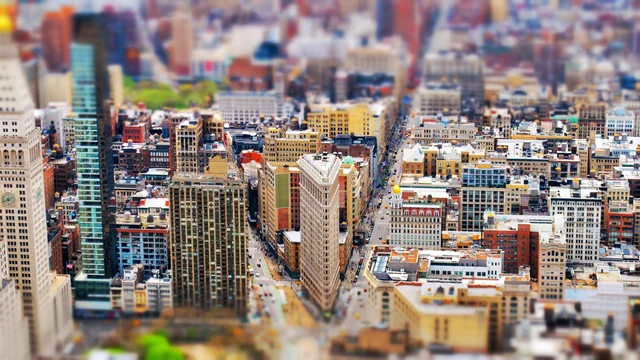

# Como funciona em câmeras
- Tilt (inclinação): Ajusta o ângulo do plano da lente em relação ao sensor da câmera. Isso altera a profundidade de campo, mantendo apenas uma parte da imagem em foco e desfocando gradualmente o restante.
- Shift (deslocamento): Move a lente paralelamente ao sensor para corrigir distorções de perspectiva, geralmente útil para fotografia de arquitetura.

# Como replicar no OpenCV

1. Pré-processamento:
As imagens são carregadas de diretórios específicos: a original, a versão desfocada e a máscara de fusão.
Assegura que todas as imagens tenham as mesmas dimensões.

2. Construção das Pirâmides Gaussianas e Laplacianas:
A pirâmide Gaussiana reduz progressivamente a resolução da imagem, criando múltiplas escalas da máscara e das imagens de entrada.
A pirâmide Laplaciana é gerada para cada imagem (original e desfocada), obtendo detalhes por diferença entre níveis sucessivos da pirâmide Gaussiana.

3. Fusão das Imagens:
Cada nível das pirâmides Laplacianas da imagem nítida e desfocada é combinado de acordo com a máscara gaussiana.
Isso resulta em uma fusão gradual entre as regiões nítidas e desfocadas.

4. Reconstrução da Imagem:
A pirâmide Laplaciana resultante é colapsada de volta à resolução original, somando os níveis expandidos.
A imagem final é normalizada para manter valores válidos de pixel (0-255).

5. Saída e Exibição:
A imagem processada é salva em um diretório de saída e exibida.

In [270]:
#IMPORTAÇÕES 

import cv2
import sys
import numpy as np
import math
import os
import scipy.signal
import shutil
from matplotlib import pyplot as plt


In [271]:
#NOSSA FUNÇÃO DE LEITURA DE IMAGEM

def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()


In [272]:
#Criando kernel para aplicação de convolução
#Recebe no parametro um valor float entre 0 e 1.
#Retorna numpy.ndarray de 5x5

def gerandoKernel(parametro):
    #Valores próximos de 0 geram uma matriz mais uniforme, com menor peso central.
    #Valores próximos de 1 criam um kernel com um peso central forte, simulando um filtro de destaque localizado.
    kernel = np.array([0.25 - parametro / 2.0, 0.25, parametro, 0.25, 0.25 - parametro / 2.0])

    print("Kernel criado", kernel)
    """ 
    np.outer() calcula o produto externo entre os vetores. Isso cria uma matriz 5x5, onde cada elemento é o produto dos elementos correspondentes no vetor.
    A matriz resultante é simétrica, com valores que suavizam gradualmente em torno do centro, dependendo de parameter.
    Neste caso, cada valor é multiplicado por todos. Ou seja, geramos 25 valores a partir de 5.
    """
    return np.outer(kernel, kernel)

gerandoKernel(0.4)

Kernel criado [0.05 0.25 0.4  0.25 0.05]


array([[0.0025, 0.0125, 0.02  , 0.0125, 0.0025],
       [0.0125, 0.0625, 0.1   , 0.0625, 0.0125],
       [0.02  , 0.1   , 0.16  , 0.1   , 0.02  ],
       [0.0125, 0.0625, 0.1   , 0.0625, 0.0125],
       [0.0025, 0.0125, 0.02  , 0.0125, 0.0025]])

In [273]:
# Fazendo a convolução da imagem, gerando um kernel a partir do parametro 0.4 e reduzindo por 2 o tamanho

#Recebe como parametro image (numpy.ndarray): a grayscale image of shape (rows, columns)
def reduzindoImage(imagem):
    kernel = gerandoKernel(0.4)

    #fazendo a convolução
    """ 
    O parametro 'same' mantem a saida igual da imagem de entrada.
    """
    saida = scipy.signal.convolve2d(imagem, kernel, 'same')
    print(f"Tamanho original da imagem {saida.shape[0], saida.shape[1]}") #Tamanho original da imagem
    """ 
    A operação de slicing saida[::2, ::2] seleciona um pixel a cada dois em ambas as direções (horizontal e vertical).
    Ou seja, na primeira dimensão (linhas) ir de 2 em 2. e na segunda dimensão (colunas) ir de 2 em 2.
    """
    novaImagem = saida[:saida.shape[0]:2, :saida.shape[1]:2]
    print(f"Imagem reduzida {novaImagem.shape}") #Tamanho reduzido
    print(novaImagem)
    
    return saida[:saida.shape[0]:2, :saida.shape[1]:2]

imagem = cv2.imread('images/original/city.jpg', 0)

r = reduzindoImage(imagem)

Kernel criado [0.05 0.25 0.4  0.25 0.05]
Tamanho original da imagem (659, 1024)
Imagem reduzida (330, 512)
[[  9.7975  13.365   13.6125 ... 175.7    175.7    166.915 ]
 [ 13.2275  18.84    19.8075 ... 251.0025 251.     238.45  ]
 [ 13.705   18.405   20.6575 ... 251.285  251.2975 238.735 ]
 ...
 [ 57.465   81.2375  80.0575 ... 101.355  101.8025  96.5425]
 [ 57.17    81.6975  80.07   ... 101.79   101.875   96.295 ]
 [ 40.5075  57.7925  56.3275 ...  71.4     71.365   67.475 ]]


In [274]:
def expandirImagem(imagem):
    #Recebe uma imagem em cinza
    #Retorna o dobro do tamanho

    #gerando o kernel
    kernel = gerandoKernel(0.4)

    #gerando imagem vazia com o dobro do tamanho
    saida = np.zeros((imagem.shape[0] * 2, imagem.shape[1] * 2))

    saida[:saida.shape[0]:2, :saida.shape[1]:2] = imagem
    
    #usando a convolução 
    saida = scipy.signal.convolve2d(saida, kernel, 'same') * 4
    return saida

imagem = cv2.imread('images/original/city.jpg', 0)
expandirImagem(imagem)

Kernel criado [0.05 0.25 0.4  0.25 0.05]


array([[ 16.83,  18.7 ,  18.54, ..., 225.9 , 203.31, 112.95],
       [ 18.  ,  20.  ,  19.9 , ..., 251.  , 225.9 , 125.5 ],
       [ 17.19,  19.1 ,  19.09, ..., 251.  , 225.9 , 125.5 ],
       ...,
       [ 74.6 ,  82.5 ,  82.3 , ..., 101.75,  92.1 ,  51.25],
       [ 67.14,  74.25,  74.07, ...,  91.75,  83.17,  46.3 ],
       [ 37.3 ,  41.25,  41.15, ...,  51.  ,  46.25,  25.75]])

In [275]:
#Construa uma pirâmide de redução a partir da imagem, reduzindo-a pelo número de níveis passados ​​pela entrada.
def piramideGaussiana(imagem, niveis):
    #A imagem deve ser em cinza
    # niveis valor int. Valor positivo. Se for nivel 0, é a propria imagem sem redução. Se for valor 1 por exemplo, uma redução.
    # o retorno deve ser uma lista de numpy.ndarrays. Na primeira posição, a imagem original, e nas posições seguintes, as reduções realizadas. 

    saida = [imagem]
    print(f"Imagem original:",imagem)
    for nivel in range(niveis):
        print(f"Nivel da piramide Gauss {nivel}")
       
        saida.append(reduzindoImage(saida[nivel]))
    

    return saida

imagem = cv2.imread('images/original/city.jpg', 0)
g = piramideGaussiana(imagem, 3)


Imagem original: [[ 21  21  19 ... 251 251 251]
 [ 19  19  19 ... 251 251 251]
 [ 18  18  19 ... 251 251 251]
 ...
 [ 82  82  83 ... 101 101 102]
 [ 83  82  84 ... 101 101 102]
 [ 83  82  84 ... 101 101 103]]
Nivel da piramide Gauss 0
Kernel criado [0.05 0.25 0.4  0.25 0.05]
Tamanho original da imagem (659, 1024)
Imagem reduzida (330, 512)
[[  9.7975  13.365   13.6125 ... 175.7    175.7    166.915 ]
 [ 13.2275  18.84    19.8075 ... 251.0025 251.     238.45  ]
 [ 13.705   18.405   20.6575 ... 251.285  251.2975 238.735 ]
 ...
 [ 57.465   81.2375  80.0575 ... 101.355  101.8025  96.5425]
 [ 57.17    81.6975  80.07   ... 101.79   101.875   96.295 ]
 [ 40.5075  57.7925  56.3275 ...  71.4     71.365   67.475 ]]
Nivel da piramide Gauss 1
Kernel criado [0.05 0.25 0.4  0.25 0.05]
Tamanho original da imagem (330, 512)
Imagem reduzida (165, 256)
[[  6.48        11.30100625  12.268225   ... 145.59914375 145.622825
  136.497725  ]
 [ 11.60426875  20.09281875  20.63835625 ... 247.31788125 247.4024687

In [276]:
#Piramide Laplaciana

#Recebe como entrada a piramide de redução. 
#Saida é uma lista de imagens, igual na piramide guassiana, cada nivel, contem a diferença entre duas camadas da piramide gaussiana. 
def piramideLaplaciana(piramideGaussiana):

    saida = []
    #Começando das 2 de baixo (maiores)
    # Nota: examine as listas, mas ignore o último elemento, pois não pode ser subtraído
    for imagem1, imagem2 in zip(piramideGaussiana[:-1], piramideGaussiana[1:]):
        # adicionar a diferença
        # Expandir a segunda e subtrair com a imagem maior (anterior da piramide)
        saida.append(imagem1 - expandirImagem(imagem2)[:imagem1.shape[0], :imagem1.shape[1]])
        
        
    saida.append(piramideGaussiana[-1])
    
    return saida

piramideLaplaciana(g)

Kernel criado [0.05 0.25 0.4  0.25 0.05]
Kernel criado [0.05 0.25 0.4  0.25 0.05]
Kernel criado [0.05 0.25 0.4  0.25 0.05]


[array([[ 12.4138  ,  10.131625,   6.73605 , ...,  89.4815  , 108.5324  ,
         172.3115  ],
        [  8.17975 ,   5.1925  ,   3.29575 , ...,  42.98375 ,  67.519   ,
         149.65875 ],
        [  5.8293  ,   2.409375,   1.180275, ...,  13.587625,  41.590025,
         135.3375  ],
        ...,
        [ 29.6473  ,  14.602875,   6.268425, ...,   4.87275 ,  16.368125,
          55.281125],
        [ 36.9545  ,  22.708125,  16.50025 , ...,  16.7475  ,  26.83    ,
          61.0575  ],
        [ 47.061225,  35.736625,  31.3578  , ...,  35.5555  ,  43.38445 ,
          71.19525 ]]),
 array([[  3.61694981,   4.66774312,   2.95014625, ...,  38.87802813,
          55.65179981, 100.71228156],
        [  4.42410125,   6.47047656,   4.7004275 , ...,  60.60360312,
          83.92061781, 146.30742656],
        [  2.27307962,   2.50132438,   1.45978506, ...,  21.01891   ,
          49.21177469, 127.28320906],
        ...,
        [ 14.1046775 ,  21.18149531,   7.63063875, ...,   8.81308594,
  

In [277]:
#Misture as duas pirâmides laplacianas ponderando-as de acordo com a máscara gaussiana.
# As pirâmides terão o mesmo número de níveis. Além disso, é garantido que cada camada tenha o mesmo formato dos níveis anteriores.
""" 
Retorna uma pirâmide Laplaciana que tenha as mesmas dimensões da pirâmides de entrada. 
Cada camada deve ser uma mistura alfa do correspondente camadas das pirâmides de entrada, ponderadas pela máscara gaussiana. 
Isto significa o seguinte cálculo para cada camada da pirâmide:

saída[i, j] = máscara_atual[i, j] * imagem_branca[i,j] + (1 - máscara_atual[i, j]) * imagem_preta[i, j]

A multiplicação por piramideGaussiana controla quais partes da imagem lapBranca contribuem para a mistura.
A multiplicação por (1 - piramideGaussiana) controla quais partes da imagem lapPreta são usadas.

Portanto:
    Pixels com valores próximos de 1 na máscara mantêm a imagem nítida
    Pixels com valores próximos de 0 substituem pela versão desfocada
    Pixels intermediarios entre os dois valores, são a transição suave
"""

def misturasLaplacianas(lapBranca, lapPreta, piramideGaussiana):
    # lapBranca = Uma pirâmide laplaciana de uma imagem
    # lapPreta = Uma pirâmide laplaciana de outra imagem
    # piramideGaussiana = uma piramide gauss para mascara.

    piramideMisturada = []
    #Itera sobre os níveis correspondentes das pirâmides
    for lapB, lapP, mascara in zip(lapBranca, lapPreta, piramideGaussiana):
        piramideMisturada.append(mascara * lapB + (1 - mascara) * lapP)

    # O resultado é uma imagem que combina ambas as imagens de entrada de forma suave, conforme especificado pela máscara em piramideGaussiana.
    return piramideMisturada

In [278]:
def colapsandoPiramide(piramide):
    """ 
    Começando na menor camada da pirâmide. Expanda a menor camada e adicione-a à segunda menor camada. 
    Em seguida, expanda a segunda camada para a menor e continue o processo até chegar à imagem maior. 
    """

    saida = piramide[-1]

    for imagem in reversed(piramide[:-1]):
        saida = imagem + expandirImagem(saida)[:imagem.shape[0], :imagem.shape[1]]
    
    return saida

In [279]:
#Esta função administra a mesclagem das duas imagens de acordo com máscara.
#Suponha que todas as imagens sejam do tipo float e retornem um tipo float.

def executarMistura(imagemPreta, imagemBranca, mascara):

    #pegando o shape
    tamanhoMinimo = min(imagemPreta.shape)
    #pelo menos 16x16 no nível mais alto da piramide Gaussiana
    """ Calculando os niveis que precisamos na pirâmide.
    1 - Calcula o logaritmo de tamanhoMinimo na base 2.
    Isso indica quantas vezes podemos dividir tamanhoMinimo por 2 antes de chegar a 1.

    2- Arredonda o valor do logaritmo para baixo (pega a parte inteira).

    3- Converte o valor arredondado em um número inteiro.

    4 - Isso reduz o valor calculado em 4 unidades.
    """
    profundidade = int(math.floor(math.log(tamanhoMinimo, 2))) - 4

    guassPiramMask = piramideGaussiana(mascara, profundidade)
    guassPiramPreta = piramideGaussiana(imagemPreta, profundidade)
    guassPiramBranca = piramideGaussiana(imagemBranca, profundidade)

    laplaPreta = piramideLaplaciana(guassPiramPreta)
    laplaBranca = piramideLaplaciana(guassPiramBranca)

    mixLaplacianas = misturasLaplacianas(laplaBranca, laplaPreta, guassPiramMask)

    saidaImagem = colapsandoPiramide(mixLaplacianas)

    #A mistura às vezes resulta em números ligeiramente fora dos limites.
    #Vamos verificar

    saidaImagem[saidaImagem < 0] = 0
    saidaImagem[saidaImagem > 255] = 255
    saidaImagem = saidaImagem.astype(np.uint8)

    return saidaImagem



In [280]:
#Função para abrir imagens

def pegarImagens(pasta):

    nomesArquivos = os.listdir(pasta)
    print(nomesArquivos)

    for img in nomesArquivos:
        preta = cv2.imread('images/original/' + img)
        branca = cv2.imread('images/blur/' +  img)
        mascara = cv2.imread('images/mask/' + img)

        if mascara is None:
            print('sem mascara', img)
            continue
        
        if branca is None:
            print('sem figura com blur', img)
            continue
        
        assert preta.shape == branca.shape, "Tamanhos diferentes"
        assert preta.shape == mascara.shape, "Tamanhos diferentes"

        """ 
        Diferente do return, que encerra a execução da função e retorna um valor, 
        o yield pausa a execução da função e salva seu estado, permitindo que ela 
        continue de onde parou quando for chamada novamente. 
        """
        yield img, branca, preta, mascara


['boat.jpg', 'city.jpg']


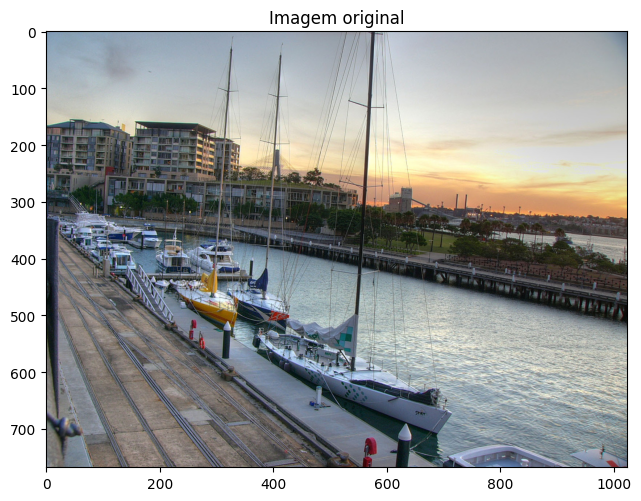

...aplicando mistura
Imagem original: [[0.99607843 0.99607843 0.99607843 ... 0.97647059 0.97647059 0.97647059]
 [0.99607843 0.99607843 0.99607843 ... 0.98039216 0.98039216 0.98039216]
 [1.         1.         1.         ... 0.98823529 0.98823529 0.98823529]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
Nivel da piramide Gauss 0
Kernel criado [0.05 0.25 0.4  0.25 0.05]
Tamanho original da imagem (768, 1024)
Imagem reduzida (384, 512)
[[0.48821569 0.69782353 0.69948039 ... 0.68751961 0.68586275 0.65084314]
 [0.69917647 0.99912745 0.99989216 ... 0.987      0.98623529 0.93658824]
 [0.7        1.         1.         ... 0.99098039 0.99098039 0.94143137]
 ...
 [0.7        1.         1.         ... 1.         1.         0.95      ]
 [0.7        1.         1.         ... 1.         1.         0.95      ]
 [0.665      0.

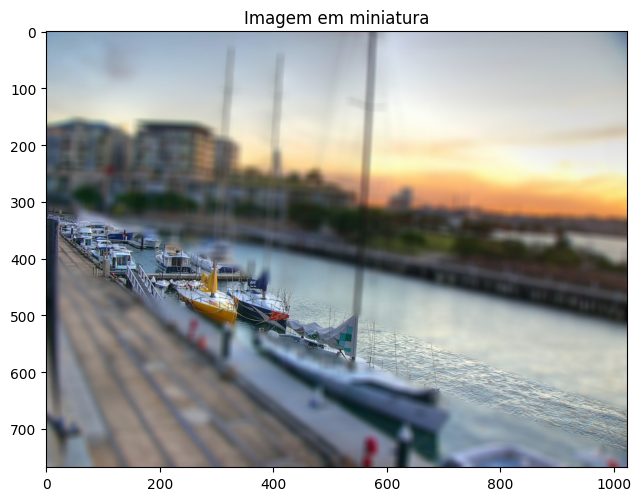

Processo finalizado


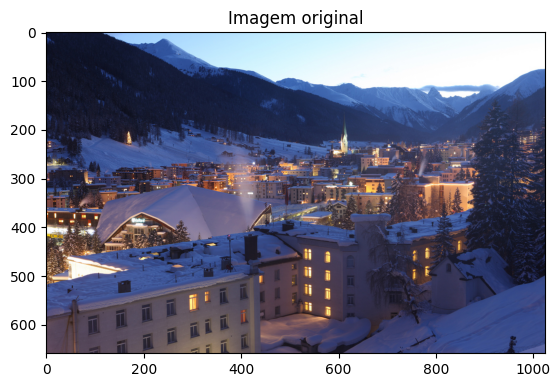

...aplicando mistura
Imagem original: [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Nivel da piramide Gauss 0
Kernel criado [0.05 0.25 0.4  0.25 0.05]
Tamanho original da imagem (659, 1024)
Imagem reduzida (330, 512)
[[0.49  0.7   0.7   ... 0.7   0.7   0.665]
 [0.7   1.    1.    ... 1.    1.    0.95 ]
 [0.7   1.    1.    ... 1.    1.    0.95 ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]
Nivel da piramide Gauss 1
Kernel criado [0.05 0.25 0.4  0.25 0.05]
Tamanho original da imagem (330, 512)
Imagem reduzida (165, 256)
[[0.3364    0.5713    0.58      ... 0.58      0.58      0.54375  ]
 [0.5713    0.970225  0.985     ... 0.985     0.985     0.9234375]
 [0.58      0.985     1.        ... 1.        1.        0.9375   ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.

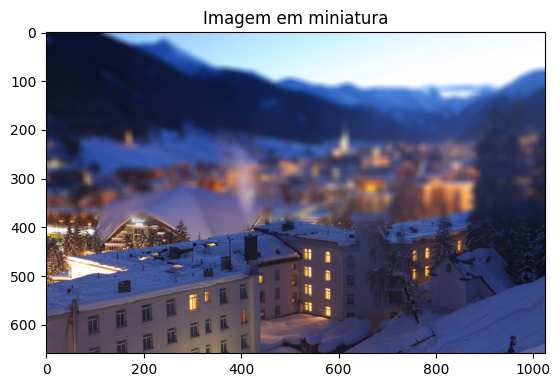

Processo finalizado


In [281]:
def main():
    pastaOrigem = 'images/original/'
    pastaSaida = 'images/output/'

    if os.path.isdir(pastaSaida):
        #remover os diretorios se tiver
        shutil.rmtree(pastaSaida)
    
    os.mkdir(pastaSaida)

    for foto, branca, preta, mascara in pegarImagens(pastaOrigem):
        imshow("Imagem original", preta)
        print('...aplicando mistura')
        preta = preta.astype(float)
        branca = branca.astype(float)
        mascara = mascara.astype(float)/255

        camadasSaida = []

        for canal in range(3):
            imagemSaida = executarMistura(preta[:,:, canal],
                                          branca[:,:, canal], 
                                          mascara[:,:,canal])
            camadasSaida.append(imagemSaida)

        imagemSaida = cv2.merge(camadasSaida)
        
        cv2.imwrite(os.path.join(pastaSaida, foto), imagemSaida)
        imshow('Imagem em miniatura', imagemSaida)
        print('Processo finalizado')

    
main()